# Water fitting workflow
- This workflow assumes that you haven't done any processing on the Raman computer,
e.g. feed in raw H$_2$O and olivine spectra
- First it finds the best possible unmix to reduce the peak-trough distance of the olivine peaks in the mixed spectra
- Then it fits a background to two positions (can choose, but approximatly that of DiDenova et al. 2017), 
- Then it calculates the area under these background curves between the baselines, using a trapezoid or simpson rule

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import scipy
from scipy import stats

## Specify your path here, and files for olivine and MI

In [2]:
path=r'G:\My Drive\Postdoc\MeltInclusion_SampleStuff\Raman\Day9\Spectra'


In [3]:
H2O_files=pf.get_Ne_files(path, ID_str='H2O',
                           file_ext='.txt', exclude_str='scan', sort=True)
Ol_files=pf.get_Ne_files(path, ID_str='Ol',
                           file_ext='.txt', exclude_str='scan', sort=True)

In [4]:
print('H2O_files')
print(H2O_files)
print('Ol_files')
print(Ol_files)

H2O_files
['08 NS20_MI1_H2O.txt', '18 NS21b_MI2_50X_H2O.txt']
Ol_files
['09 NS20_MI1_Ol.txt', '19 NS21b_MI2_50X_Ol.txt']


In [5]:
MI_file='18 NS21b_MI2_50X_H2O.txt'
Ol_file='19 NS21b_MI2_50X_Ol.txt'
filetype='Witec_ASCII'

## Load in melt inclusion and olivine data

In [6]:
MI=pf.get_data(path=path, filename=MI_file,
                  filetype=filetype)
Ol=pf.get_data(path=path, filename=Ol_file,
                  filetype=filetype)

18 NS21b_MI2_50X_H2O.txt
19 NS21b_MI2_50X_Ol.txt


## 1. trim the signal around the olivine peaks
- This function trims the spectra aroudn the olivine peaks (default 800-900, but you can change this)
- It then uses Scipy find peaks to find the 2 biggest peaks, then the trough position between them
- This is vital to do the unmixing of the olivine spectra

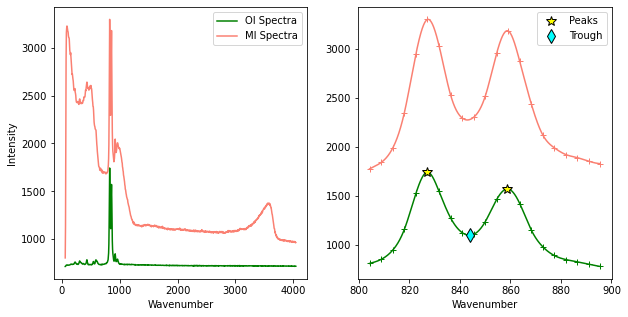

In [7]:
(x_new, y_cub_MI, y_cub_Ol, peak_pos_Ol, 
 peak_height_Ol, trough_x, trough_y)=pf.smooth_and_trim_around_olivine(x_range=[800,900],
            Ol_spectra=Ol, MI_spectra=MI)

## 2. Unmix the olivine spectra 
- Logic is find 2 strong olivine peaks. Also find trough. As you progressively subtract out olivine, eventually the peaks invert, and the trough becomes a peak once you have subtracted out too much olivine. We are looking for the point at which the trough position is higher than a line between the two peak positions.
- In this example, its the red vs. blue line. The function then finds the best mixing ratio where the distance between the trough and peak line is 0 by extrapolation. 

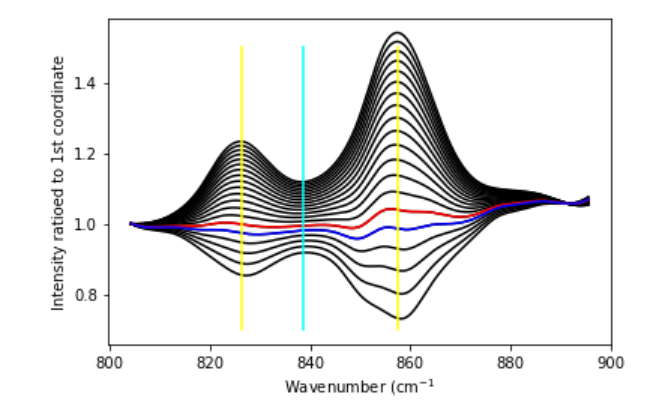

best fit proportion
1.7383476695339068


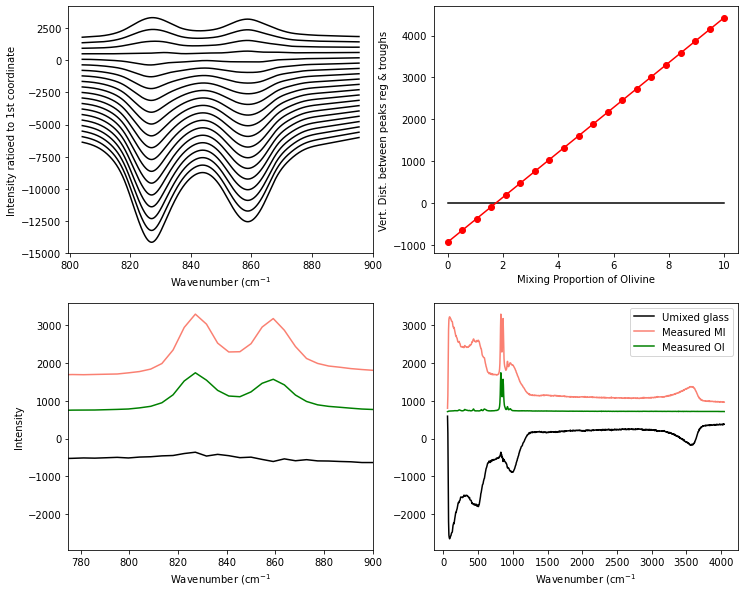

In [8]:
MI_Mix_Best, ideal_mix, Dist, MI_Mix, X=pf.make_evaluate_mixed_spectra(
Ol_spectra=Ol, MI_spectra=MI,smoothed_Ol_y=y_cub_Ol, 
smoothed_MI_y=y_cub_MI, 
x_new=x_new, peak_pos_Ol=peak_pos_Ol, trough_x=trough_x, trough_y=trough_y,
X_min=0, X_max=10, av_width=2)


## Silica region Area calc

y coordinate of tie coordinate
204.2008344687078
mean y coordinate around peak
-409.9064263528852
Peak negative, spectra inverted


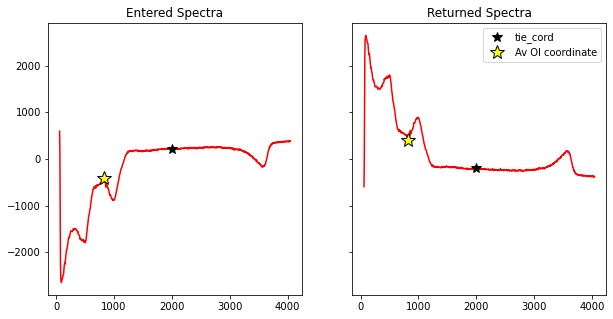

In [9]:
Spectra=pf.check_if_spectra_negative(Spectra=MI_Mix_Best, peak_pos_Ol=peak_pos_Ol,
                                     override=False, flip=False)

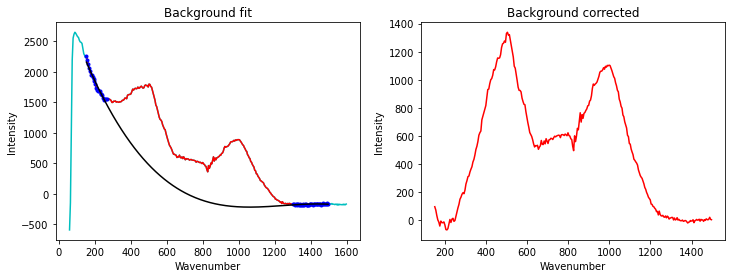

In [10]:
df_sil=pf.fit_area_for_silicate_region(Spectra=Spectra, lower_range_sil=[150, 270], 
                                       upper_range_sil=[1300, 1500],
sigma_sil=10, exclude_range1_sil=None, exclude_range2_sil=None, N_poly_sil=3, plot_figure=True,
fit_sil='poly')

## Same for H2O curve

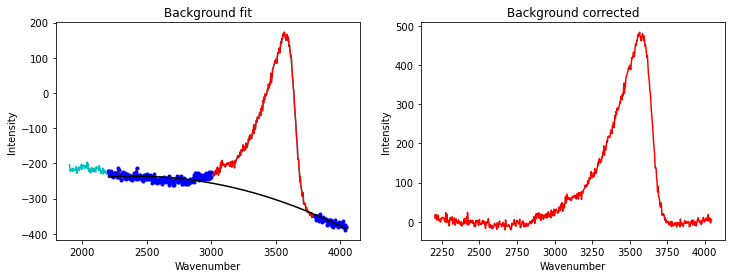

In [11]:
df_water=pf.fit_area_for_water_region(Spectra=Spectra, lower_range_water=[2200, 3000], 
upper_range_water=[3800, 4100],
sigma_water=5, exclude_range1_water=None, exclude_range2_water=None,
N_poly_water=2, plot_figure=True, fit_water='poly')

## Stitch these dataframes together 

In [14]:
df_stitch=pf.stitch_dataframes_together(df_sil=df_sil, df_water=df_water, Ol_file=Ol_file, MI_file=MI_file)  
df_stitch.to_clipboard(excel=True, header=False, index=None)

In [13]:
df_stitch

,Olivine filename,MI filename,Trap_H2O_Sil,Simp_H2O_Sil,Sil_LHS_Back1,Sil_LHS_Back2,Sil_RHS_Back1,Sil_RHS_Back2,Sil_N_Poly,Sil_Trapezoid_Area,Sil_Simpson_Area,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly,Water_Trapezoid_Area,Water_Simpson_Area
0,19 NS21b_MI2_50X_Ol.txt,18 NS21b_MI2_50X_H2O.txt,0.239894,0.239695,150,270,1300,1500,3,720606.563136,720940.681551,2200,3000,3800,4100,2,172868.909017,172805.56386
